# 1. 1D Linear Convection

We consider the 1d linear Convection equation, under a constant velocity

$$
\partial_t u + c \partial_x u = 0
$$

If we denote $u_0(x) := u(x,t)$ then the exact solution is 
$$
u(x,t) = u_0(x-ct)
$$


## Using Finite Differences

our problem is then discretized as
$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 $$

In [10]:
# needed imports
from numpy import zeros, ones, linspace
from matplotlib.pyplot import plot, show
%matplotlib inline

In [11]:
nx = 401  
dx = 2 / (nx-1)
T = 0.625  # T final time
dt = .0025  # time step 
c = 1      # wavespeed 
niter = int(T / dt)

In [12]:
# Initial condition
from numpy import exp
u0 = lambda x: exp(-(x-.3)**2/.05**2)

grid = linspace(0., 1., nx)
u = u0(grid) 

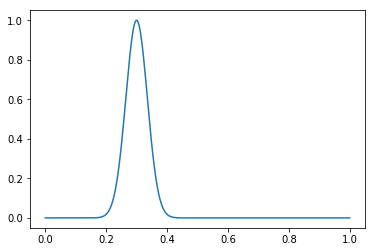

In [13]:
plot(grid, u) ; show()

In [14]:
un = ones(nx)  
for n in range(niter):  
    un[:] = u[:] 
    for i in range(1, nx): 
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])

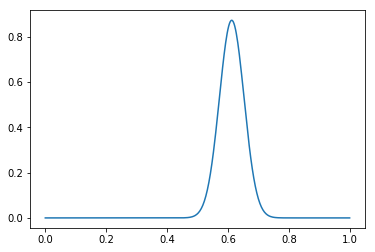

In [15]:
plot(grid, u) ; show()

## Using IGA

### Time scheme

$$\frac{u^{n+1}-u^n}{\Delta t} + c \partial_x u^{n+1} = 0 $$

$$ \left(I + c \Delta t \partial_x \right) u^{n+1} = u^n $$

### Weak formulation

$$\langle u^{n+1}, v \rangle = (1 - c \Delta t) \langle \partial_x u^n, v \rangle$$
expending $u^n$ over the fem basis, we get the linear system

$$M U^{n+1} = (1 - c \Delta t) A U^n$$

where

$$
M_{ij} = \langle b_i, b_j \rangle
$$

$$
A_{ij} = \langle b_i, \partial_x b_j \rangle
$$


In [16]:
# needed imports
from spl.linalg.stencil import VectorSpace, Vector, Matrix
from spl.core.interface import make_open_knots
from spl.fem.splines import SplineSpace
from spl.linalg.solvers import cg
from utils import assemble_matrix_1d

In [42]:
p  = 3    # spline degree
ne = 128   # number of elements
n  = p + ne
    
# to be removed
knots = make_open_knots(p, n)

# create a finite element space
V = SplineSpace(knots, p)

In [43]:
# kernel for mass matrix
def kernel_M(p1, k1, basis, w, mat):
    mat[:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis[il_1, 0, g1]
                bi_x = basis[il_1, 1, g1]

                bj_0 = basis[jl_1, 0, g1]
                bj_x = basis[jl_1, 1, g1]

                wvol = w[g1]

                v += (bi_0 * bj_0) * wvol
            mat[il_1, p1 + jl_1 - il_1] = v
            
# kernel for Advection matrix
def kernel_A(p1, k1, basis, w, mat):
    mat[:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis[il_1, 0, g1]
                bi_x = basis[il_1, 1, g1]

                bj_0 = basis[jl_1, 0, g1]
                bj_x = basis[jl_1, 1, g1]

                wvol = w[g1]

                v += (bi_0 * bj_x) * wvol
            mat[il_1, p1 + jl_1 - il_1] = v

In [44]:
M = assemble_matrix_1d(V, kernel_M).tocsr()
A = assemble_matrix_1d(V, kernel_A).tocsr()

In [45]:
from numpy import linspace
from scipy.sparse.linalg import cg, gmres

dt = 0.00001

un = u0(linspace(0.,1.,V.nbasis))

for i in range(0, 1):
    b = (1. - dt * c) * A.dot(un)
    un, status = cg(M, b, tol=1.e-5, maxiter=1000)


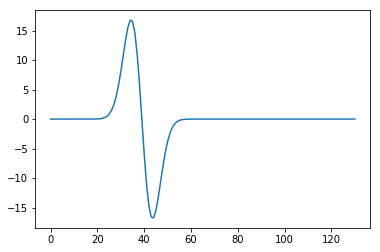

In [46]:
plot(un) ; show()

In [58]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()